<a href="https://colab.research.google.com/github/LeoProvorov/MyProjects/blob/master/ML_DiKaprio_visual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Что общего у Ди Каприо и машинного обучения?**

In [ ]:
import pandas as pd
import numpy as np

from google.colab import files

In [ ]:
files.upload() # Загрузка архива с кегл. Закидываем файл json сюда

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"leoprovorov","key":"f72a24d5b548dd8901a47dbea22a4373"}'}

In [ ]:
# Расположение файла для аутентификации на kaggle.com и получение прав доступа
!mkdir -p ~/.kaggle
!mv -i kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

mv: overwrite '/root/.kaggle/kaggle.json'? n


In [ ]:
# загрузка данных
!kaggle competitions download -c titanic

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Чтение данных
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_data_visual = pd.read_csv('train.csv')

In [ ]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# Считывание целевой переменной в отдельный массив
len_train_data = len(train_data)
y = train_data['Survived'].values
print('Количество позиций для обучения', len_train_data)
print(y[:10])

Количество позиций для обучения 891
[0 1 1 1 0 0 0 0 1 1]


In [ ]:
# Переиндексируем данные и удаляем некоторые столбцы
train_data.index = train_data.PassengerId

del train_data['Survived']
del train_data['PassengerId']

test_data.index = test_data.PassengerId
del test_data['PassengerId']

train_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
#  Сливаем данные в один датасет, для более полной визуализации
all_data = pd.concat([train_data,test_data])
print('Размер полученных данных:', all_data.shape)
all_data.head(2)

Размер полученных данных: (1309, 10)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [ ]:
# Переводим номер кабины в 0-1
all_data['Has_Cabin'] = all_data['Cabin'].apply(lambda x: 0 if type(x) == float else 1) 

# Размер семьи
all_data['Family_Size'] = all_data['SibSp'] + all_data['Parch'] + 1

# Признак одинокого плавания
all_data['Is_alone'] = all_data['Family_Size'].apply(lambda x: 0 if x>1 else 1)


In [ ]:
# Использование регулярных выражений для поиска титулов в именах
import re
def get_title(name):
    title_search = re.search('([A-Za-z]+)\.', name) # Берём все буквы до точки
    if title_search:
        return title_search.group(1)
    return ""

# Применяем к столбцу Name
all_data['Title'] = all_data['Name'].apply(get_title)


In [ ]:
# просмотр титулов и из кол-во
all_data['Title'].value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Major         2
Mlle          2
Ms            2
Don           1
Mme           1
Sir           1
Jonkheer      1
Countess      1
Lady          1
Dona          1
Capt          1
Name: Title, dtype: int64

In [ ]:
# исправление неточностей в титулах и замена редких на нейтральное значение
all_data['Title'] = all_data['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Rev', 'Major', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
all_data['Title'] = all_data['Title'].replace('Mlle', 'Miss')
all_data['Title'] = all_data['Title'].replace('Ms', 'Miss')
all_data['Title'] = all_data['Title'].replace('Mme', 'Mrs')

In [ ]:
all_data['Title'].value_counts()

Mr        757
Miss      264
Mrs       198
Master     61
Rare       29
Name: Title, dtype: int64

In [ ]:
# Дропаем ненужное
all_data = all_data.drop(["Name", 'Ticket', 'Cabin'], axis = 1)

In [ ]:
all_data.head(2)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Has_Cabin,Family_Size,Is_alone,Title
PassengerId,,,,,,,,,,,
1,3,male,22.0,1,0,7.2500,S,0,2,0,Mr
2,1,female,38.0,1,0,71.2833,C,1,2,0,Mrs


In [ ]:
# Переводим оставшиеся недообработанные столбцы в числовой вид
title_mapping = {'Mr': 1, "Master": 2, "Mrs":3, "Miss":4, "Rare": 5}
all_data["Title"] = all_data["Title"].map(title_mapping)
all_data["Title"] = all_data['Title'].fillna(0) # здесь не нужен, но всёравно сделаем

In [ ]:
map_dict_sex = {'male': 1, 'female': 0}

all_data["Sex"] = all_data["Sex"].map(map_dict_sex)

In [ ]:
map_dict_embarked = {'S': 0, 'C': 1, 'Q': 2}

all_data['Embarked'] = all_data['Embarked'].map(map_dict_embarked)

In [ ]:
all_data.head(3)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Has_Cabin,Family_Size,Is_alone,Title
PassengerId,,,,,,,,,,,
1,3,1,22.0,1,0,7.2500,0.0,0,2,0,1
2,1,0,38.0,1,0,71.2833,1.0,1,2,0,3
3,3,0,26.0,0,0,7.9250,0.0,0,1,1,4


In [ ]:
all_data.info()
#видим пропуски в данных, особенно в возрасте

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pclass       1309 non-null   int64  
 1   Sex          1309 non-null   int64  
 2   Age          1046 non-null   float64
 3   SibSp        1309 non-null   int64  
 4   Parch        1309 non-null   int64  
 5   Fare         1308 non-null   float64
 6   Embarked     1307 non-null   float64
 7   Has_Cabin    1309 non-null   int64  
 8   Family_Size  1309 non-null   int64  
 9   Is_alone     1309 non-null   int64  
 10  Title        1309 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 122.7 KB


In [ ]:
# Избавление от пропусков в данных
all_data['Fare'] = all_data['Fare'].fillna(value=all_data['Fare'].median())
all_data['Embarked'] = all_data['Embarked'].fillna(value=0)

In [ ]:
all_data['Age'] = all_data['Age'].fillna(value=all_data['Age'].mean())

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pclass       1309 non-null   int64  
 1   Sex          1309 non-null   int64  
 2   Age          1309 non-null   float64
 3   SibSp        1309 non-null   int64  
 4   Parch        1309 non-null   int64  
 5   Fare         1309 non-null   float64
 6   Embarked     1309 non-null   float64
 7   Has_Cabin    1309 non-null   int64  
 8   Family_Size  1309 non-null   int64  
 9   Is_alone     1309 non-null   int64  
 10  Title        1309 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 122.7 KB


In [ ]:
all_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Has_Cabin,Family_Size,Is_alone,Title
PassengerId,,,,,,,,,,,
1,3,1,22.0,1,0,7.2500,0.0,0,2,0,1
2,1,0,38.0,1,0,71.2833,1.0,1,2,0,3
3,3,0,26.0,0,0,7.9250,0.0,0,1,1,4
4,1,0,35.0,1,0,53.1000,0.0,1,2,0,3
5,3,1,35.0,0,0,8.0500,0.0,0,1,1,1


**Дополнительная предоброботка данных**

In [ ]:
# Добавление названий категориальных столбцов
categorial_culumns_names = ['Pclass', 'Sex', 'SibSp', 'Parch',
                            'Embarked', 'Has_Cabin', 'Family_Size',
                            'Is_alone', 'Title']

# Кодируем категориальные данные по принципу One-Hot
from sklearn.preprocessing import  OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
encoded_categorial_columns = pd.DataFrame(
                                        one_hot_encoder.fit_transform(
                                        all_data[categorial_culumns_names]),
                                        index=all_data.index)

encoded_categorial_columns.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
8,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
9,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# Соединяем закодированные категориальные признаки с остальными
res_data_all = all_data.join(encoded_categorial_columns)
res_data_all.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Has_Cabin,Family_Size,Is_alone,Title,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3,1,22.0,1,0,7.2500,0.0,0,2,0,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,0,38.0,1,0,71.2833,1.0,1,2,0,3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3,0,26.0,0,0,7.9250,0.0,0,1,1,4,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1,0,35.0,1,0,53.1000,0.0,1,2,0,3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5,3,1,35.0,0,0,8.0500,0.0,0,1,1,1,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
# избавлемся от категориальных столбцов в res_data_all
res_data_all = res_data_all.drop(categorial_culumns_names, axis=1)
res_data_all.head()

,Age,Fare,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,22.0,7.2500,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,38.0,71.2833,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,26.0,7.9250,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,35.0,53.1000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5,35.0,8.0500,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
# Нормализуем данные
from sklearn.preprocessing import  StandardScaler
nn_scaler = StandardScaler()
res_data_all_scaled = nn_scaler.fit_transform(res_data_all)

print(res_data_all_scaled.shape)
print(res_data_all_scaled[0])

(1309, 43)
[-0.61197171 -0.50329106 -0.57235147 -0.51808383  0.91992518 -0.74349692
  0.74349692 -1.45999279  1.76166066 -0.18206914 -0.12456285 -0.13074409
 -0.06785837 -0.08320503  0.55352256 -0.3863337  -0.3073786  -0.0784163
 -0.06785837 -0.06785837 -0.03911805 -0.03911805  0.65501092 -0.50976981
 -0.32204029  0.53937651 -0.53937651 -1.23375767  2.1378056  -0.37183447
 -0.18429662 -0.13074409 -0.13953639 -0.11123994 -0.0784163  -0.09205746
  1.23375767 -1.23375767  0.85392868 -0.22108416 -0.42215853 -0.50262469
 -0.15051993]


# **ML**

In [ ]:
# Разбиваем на обучение и валидацию
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(res_data_all_scaled[:len_train_data],
                                                  y,
                                                  test_size=0.10,
                                                  random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=3,
                               min_samples_split=5,
                               random_state=0)
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
# Оценка качества работы сети
from sklearn.metrics import  accuracy_score
y_predict = model.predict(X_test)
print(accuracy_score(y_test, y_predict))

0.8555555555555555


1309

In [ ]:
# Получение предсказаний для участия в конкурсе
y_compet = model.predict(res_data_all_scaled[len_train_data:])
print(y_compet.shape)
print(y_compet)


(418,)
[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1
 1 0 0 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0
 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 0 0 0 1]


# **Для участия в конкурсе на keggle**

In [ ]:

pass_id = all_data[len_train_data:].index.values
submit = pd.DataFrame({'PassengerId': pass_id, 'Survived': y_compet})
# Создаю сабмишн файл
filename = 'Titanic_Prediction.csv'
submit.to_csv(filename, index=False)
print('Saved file: ' + filename)

Saved file: Titanic_Prediction.csv


In [ ]:
!ls

gender_submission.csv  sample_data  Titanic_Prediction.csv
kaggle.json	       test.csv     train.csv


In [ ]:
!kaggle competitions submit -c titanic -f Titanic_Prediction.csv -m "Submit DTree 1"

100% 2.77k/2.77k [00:00<00:00, 13.3kB/s]
Successfully submitted to Titanic: Machine Learning from Disaster

# Продолжение ML Случайный лес.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_data[:len_train_data],
                                                    y,
                                                    test_size=0.10,
                                                    random_state=42)

In [ ]:
from sklearn.ensemble import  RandomForestClassifier
model = RandomForestClassifier(random_state=1,
                               max_depth=5,
                               n_estimators=250,
                               max_features='auto')
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [ ]:
from sklearn.metrics import accuracy_score
y_predict = model.predict(X_test)
accuracy_score(y_test, y_predict)

0.8444444444444444

In [ ]:
# Получение предсказаний для участия в конкурсе
y_compet = model.predict(all_data[len_train_data:])
print(y_compet.shape)
print(y_compet)

(418,)
[0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 1]


In [ ]:
pass_id = all_data[len_train_data:].index.values
submit = pd.DataFrame({'PassengerId': pass_id, 'Survived': y_compet})

filename = 'Titanic_Prediction_Forest.csv'
submit.to_csv(filename, index=False)
print('Saved file: ' + filename)

Saved file: Titanic_Prediction_Forest.csv


# Отправляем на kaggle

In [ ]:
!ls

gender_submission.csv  sample_data  Titanic_Prediction.csv	   train.csv
kaggle.json	       test.csv     Titanic_Prediction_Forest.csv


In [ ]:
!kaggle competitions submit -c titanic -f Titanic_Prediction_Forest.csv -m 'Submit RFT'

100% 2.77k/2.77k [00:00<00:00, 9.01kB/s]
Successfully submitted to Titanic: Machine Learning from Disaster

# **Градиентный бустинг**

In [ ]:
from sklearn.model_selection import  train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_data[:len_train_data],
                                                    y,
                                                    test_size=0.10,
                                                    random_state=42)

In [ ]:
import xgboost as xgb
model=xgb.XGBClassifier(random_state=1, learning_rate=0.0001)

model.fit(X_train,y_train)
model.score(X_test,y_test)

0.8555555555555555

In [ ]:
# Получение предсказаний для участия в конкурсе
y_compet = model.predict(all_data[len_train_data:])
print(y_compet.shape)
print(y_compet)

(418,)
[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1
 1 0 0 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0
 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 0 0 0 1]


# Отправляем на kaggle

In [ ]:
pass_id = all_data[len_train_data:].index.values
submit = pd.DataFrame({'PassengerId': pass_id, 'Survived': y_compet})

filename = 'Titanic_Prediction_XGBoost.csv'
submit.to_csv(filename, index=False)
print('Saved file: ' + filename)

Saved file: Titanic_Prediction_XGBoost.csv


In [ ]:
!kaggle competitions submit -c titanic -f Titanic_Prediction_XGBoost.csv -m 'Submit RFT'

100% 2.77k/2.77k [00:00<00:00, 10.7kB/s]
Successfully submitted to Titanic: Machine Learning from Disaster

# **Нейронные сети**

In [ ]:
from sklearn.model_selection import  train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_data[:len_train_data],
                                                    y,
                                                    test_size=0.10,
                                                    random_state=42)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(256, activation='tanh', input_shape=(X_train.shape[1],)))
model.add(Dense(1024, activation='tanh'))
model.add(Dense(512, activation='tanh'))
model.add(Dense(256, activation='tanh'))
model.add(Dense(256, activation='tanh'))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               3072      
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dense_8 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 988,417
Trainable params: 988,417
Non-trainable params: 0
________________________________________________

In [ ]:
model.fit(X_train,
          y_train,
          batch_size=100,
          epochs=300,
          validation_data=(X_test, y_test))

In [ ]:
 y_compet = model.predict(all_data[len_train_data:])



In [ ]:
y_compet = (y_compet > 0.5).astype('int64').reshape((len(y_compet),))

In [ ]:
y_compet

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

# **Часть 2. Статистический анализ и основная визуализация**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
train_data_visual.index = train_data_visual.PassengerId
del train_data_visual['PassengerId']

In [ ]:
train_data_visual.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
all_data_stat = train_data_visual.copy() 

# Переводим номер кабины в 0-1
all_data_stat['Has_Cabin'] = all_data_stat['Cabin'].apply(lambda x: 0 if type(x) == float else 1) 

# Размер семьи
all_data_stat['Family_Size'] = all_data_stat['SibSp'] + all_data['Parch'] + 1

# Признак одинокого плавания
all_data_stat['Is_alone'] = all_data_stat['Family_Size'].apply(lambda x: 0 if x>1 else 1)


In [ ]:
# Использование регулярных выражений для поиска титулов в именах
import re
def get_title(name):
    title_search = re.search('([A-Za-z]+)\.', name) # Берём все буквы до точки
    if title_search:
        return title_search.group(1)
    return ""

# Применяем к столбцу Name
all_data_stat['Title'] = all_data_stat['Name'].apply(get_title)


In [ ]:
# исправление неточностей в титулах и замена редких на нейтральное значение
all_data_stat['Title'] = all_data_stat['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Rev', 'Major', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
all_data_stat['Title'] = all_data_stat['Title'].replace('Mlle', 'Miss')
all_data_stat['Title'] = all_data_stat['Title'].replace('Ms', 'Miss')

In [ ]:
# Дропаем ненужное
all_data_stat = all_data_stat.drop(["Name", 'Ticket', 'Cabin'], axis = 1)

In [ ]:
all_data_stat.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Has_Cabin,Family_Size,Is_alone,Title
PassengerId,,,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,0,2.0,0,Mr
2,1,1,female,38.0,1,0,71.2833,C,1,2.0,0,Mrs
3,1,3,female,26.0,0,0,7.9250,S,0,1.0,1,Miss
4,1,1,female,35.0,1,0,53.1000,S,1,2.0,0,Mrs
5,0,3,male,35.0,0,0,8.0500,S,0,1.0,1,Mr


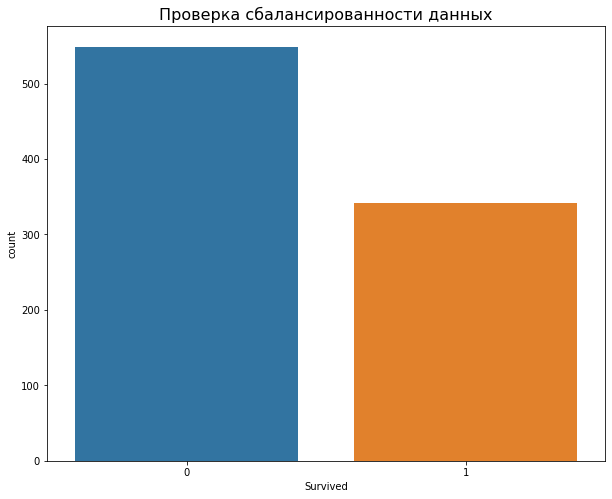

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Проверка сбалансированности данных', fontsize=16)
sns.countplot(data=all_data_stat, x='Survived')

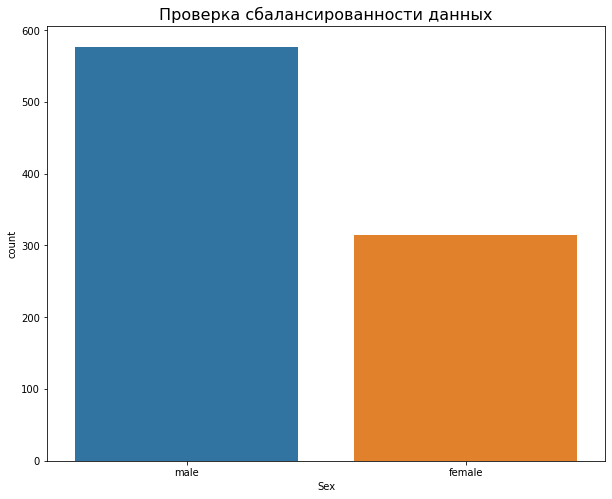

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Проверка сбалансированности данных', fontsize=16)
sns.countplot(data=all_data_stat, x='Sex')

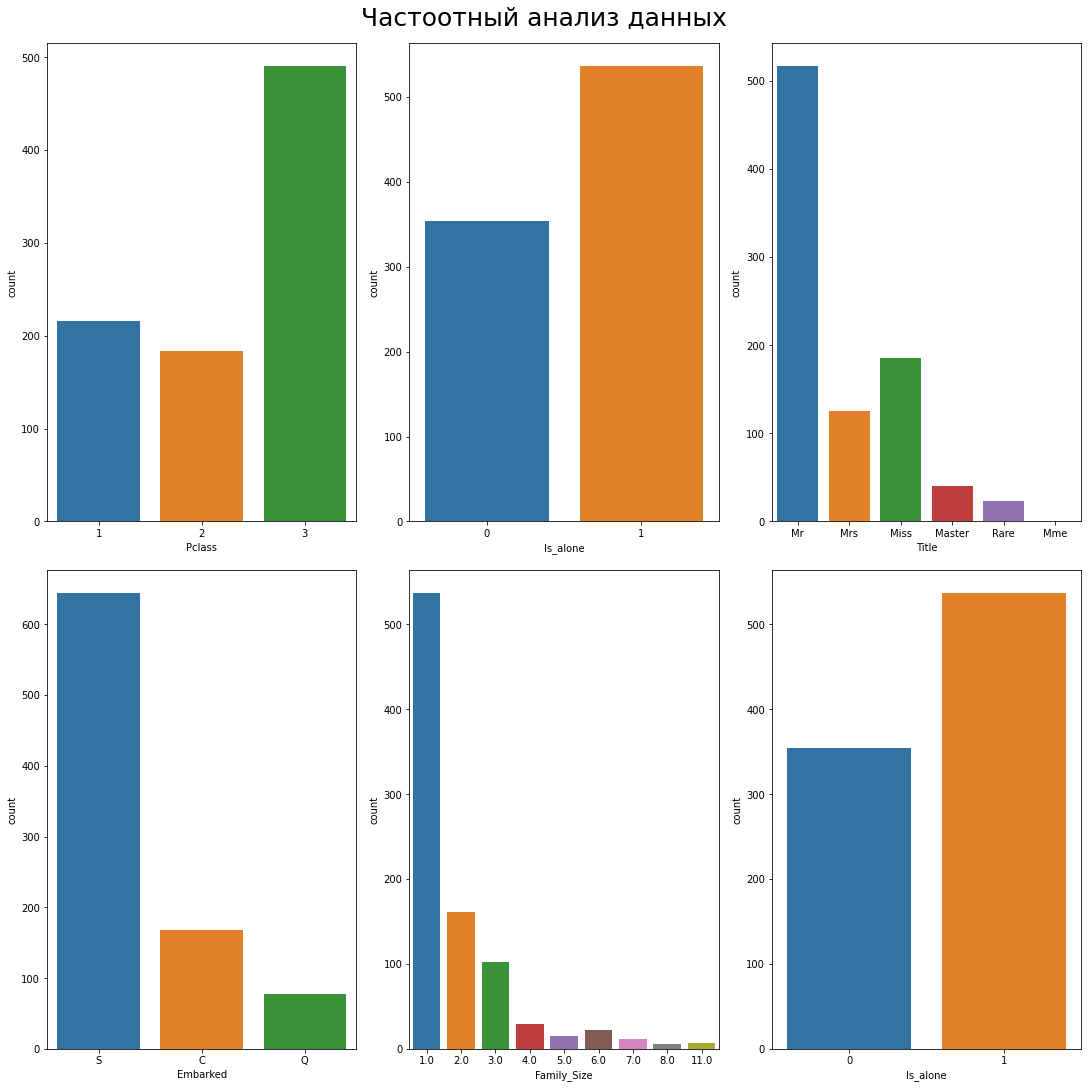

In [ ]:
fig, ax = plt.subplots(2, 3, sharex=False, sharey=False,
                       figsize=(15,15), constrained_layout=True)
fig.suptitle('Частоотный анализ данных', fontsize=25)

sns.countplot(x="Pclass", data=all_data_stat, ax=ax[0,0])
sns.countplot(x="Is_alone", data=all_data_stat, ax=ax[0,1])
sns.countplot(x="Title", data=all_data_stat, ax=ax[0,2])

sns.countplot(x="Embarked", data=all_data_stat, ax=ax[1,0])
sns.countplot(x="Family_Size", data=all_data_stat, ax=ax[1,1])
sns.countplot(x="Is_alone", data=all_data_stat, ax=ax[1,2])



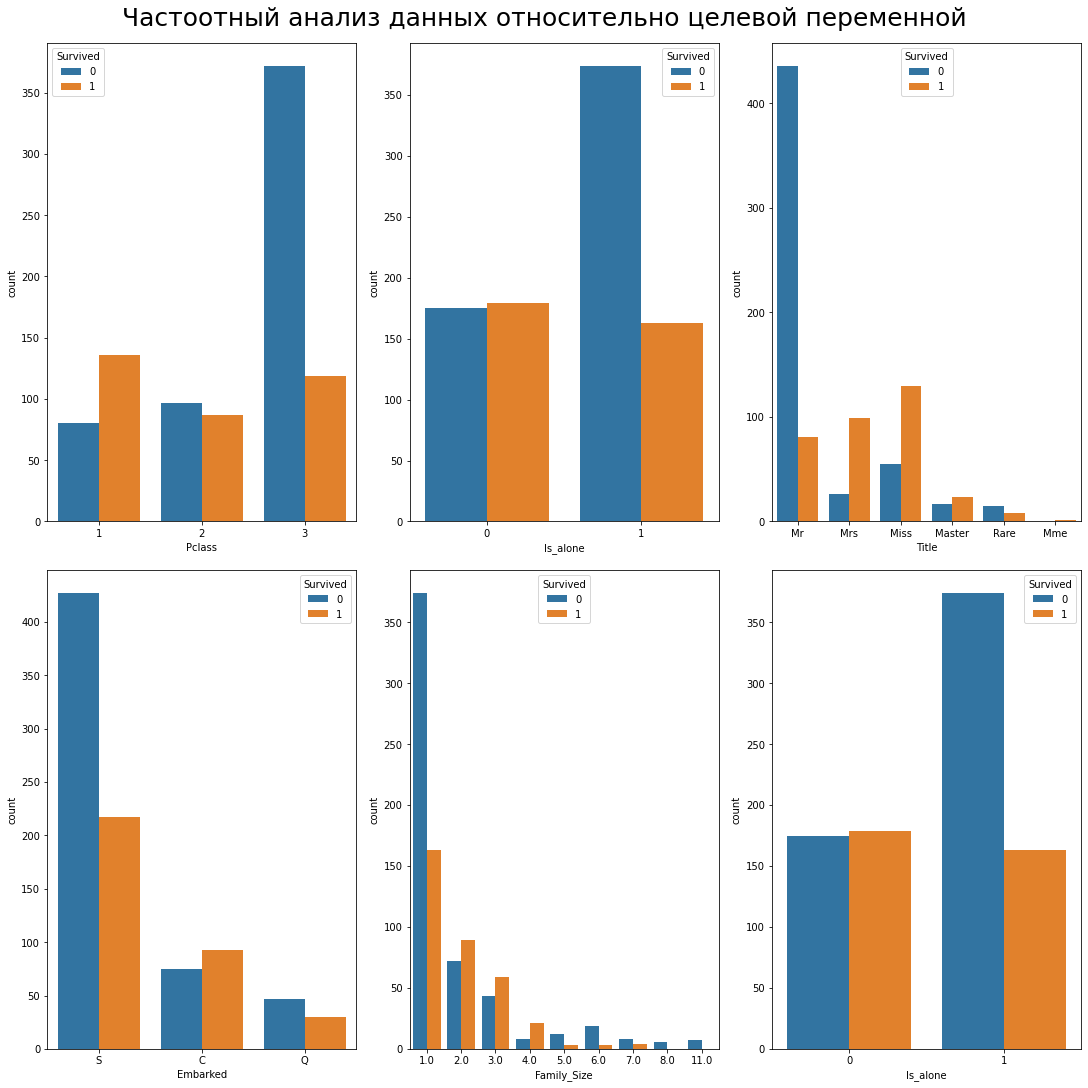

In [ ]:
fig, ax = plt.subplots(2, 3, sharex=False, sharey=False,
                       figsize=(15,15), constrained_layout=True)
fig.suptitle('Частоотный анализ данных относительно целевой переменной', fontsize=25)

sns.countplot(x="Pclass", hue='Survived', data=all_data_stat, ax=ax[0,0])
sns.countplot(x="Is_alone", hue='Survived', data=all_data_stat, ax=ax[0,1])
sns.countplot(x="Title", hue='Survived', data=all_data_stat, ax=ax[0,2])

sns.countplot(x="Embarked", hue='Survived', data=all_data_stat, ax=ax[1,0])
sns.countplot(x="Family_Size", hue='Survived', data=all_data_stat, ax=ax[1,1])
sns.countplot(x="Is_alone", hue='Survived', data=all_data_stat, ax=ax[1,2])


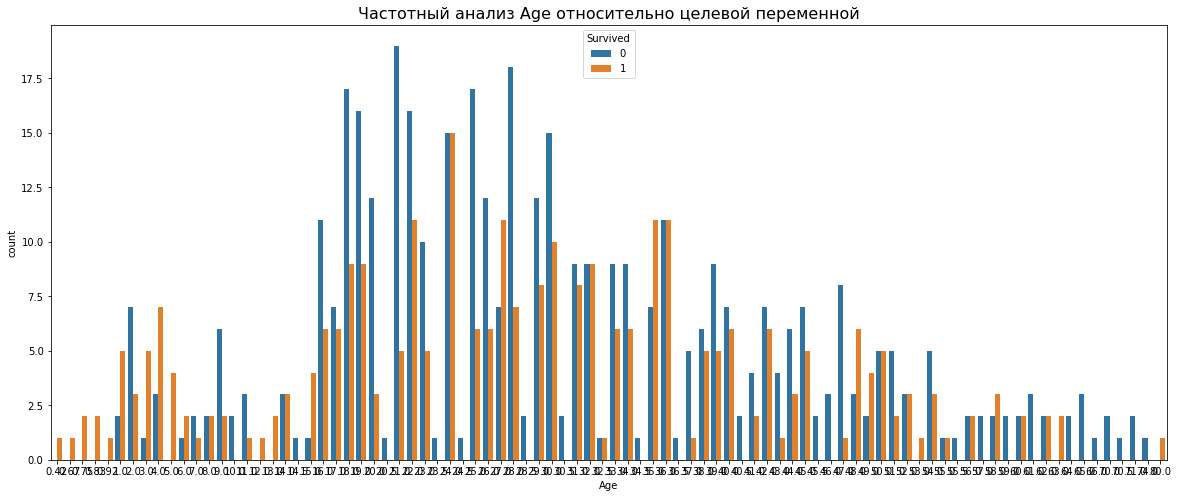

In [ ]:
 plt.figure(figsize=(20,8))
 plt.title("Частотный анализ Age относительно целевой переменной", fontsize=16)
 sns.countplot(x="Age", hue='Survived', data=all_data_stat)

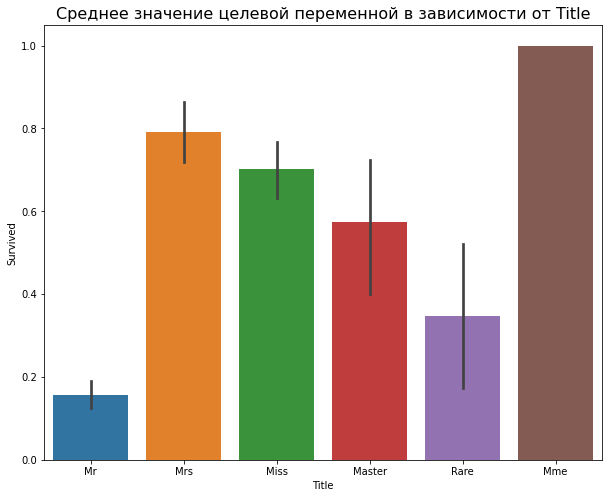

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Среднее значение целевой переменной в зависимости от Title',
          fontsize=16)
sns.barplot(x='Title', y='Survived', data=all_data_stat)

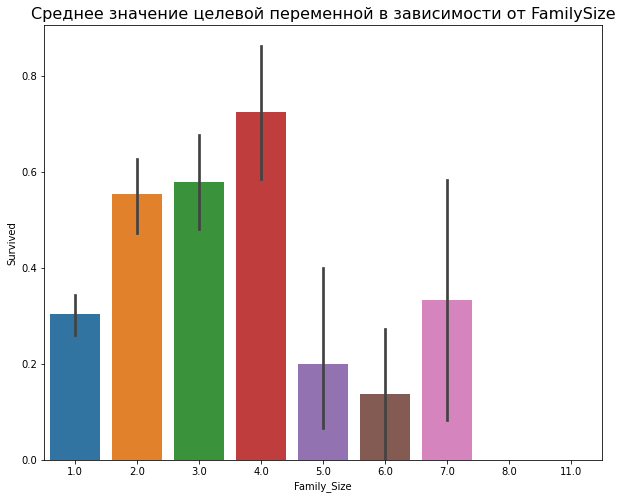

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Среднее значение целевой переменной в зависимости от FamilySize',
          fontsize=16)
sns.barplot(x='Family_Size', y='Survived', data=all_data_stat)

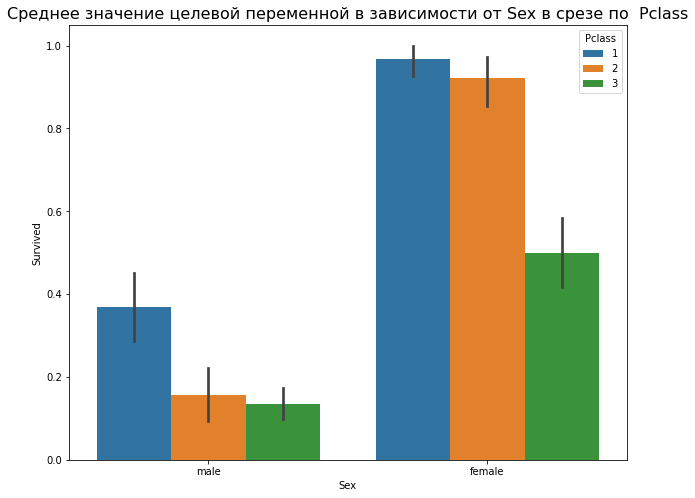

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Среднее значение целевой переменной в зависимости от Sex в срезе по  Pclass',
          fontsize=16)
sns.barplot(x='Sex', y='Survived', hue='Pclass', data=all_data_stat)

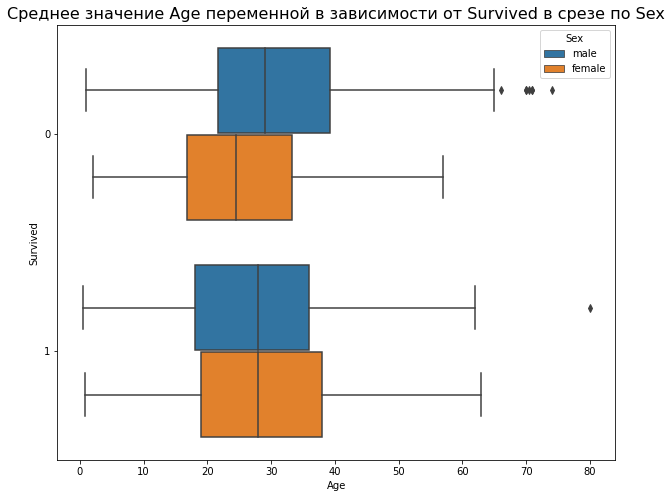

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Среднее значение Age переменной в зависимости от Survived в срезе по Sex',
          fontsize=16)
sns.boxplot(x='Age', y='Survived',hue='Sex', orient='h', data=all_data_stat)

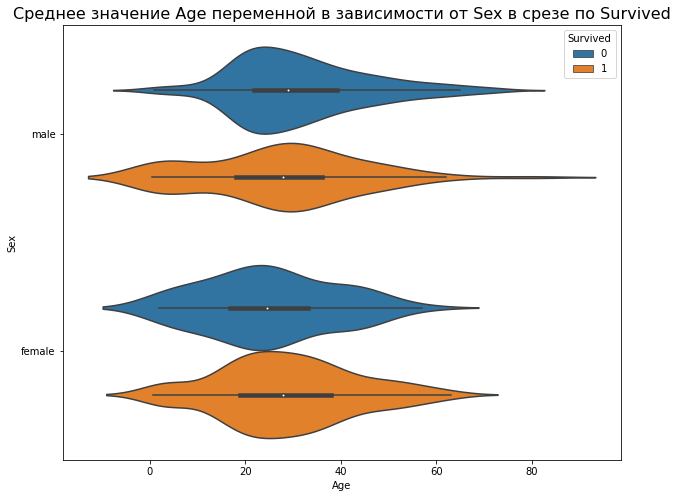

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Среднее значение Age переменной в зависимости от Sex в срезе по Survived',
          fontsize=16)
sns.violinplot(x='Age', y='Sex',hue='Survived', orient='h', data=all_data_stat)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


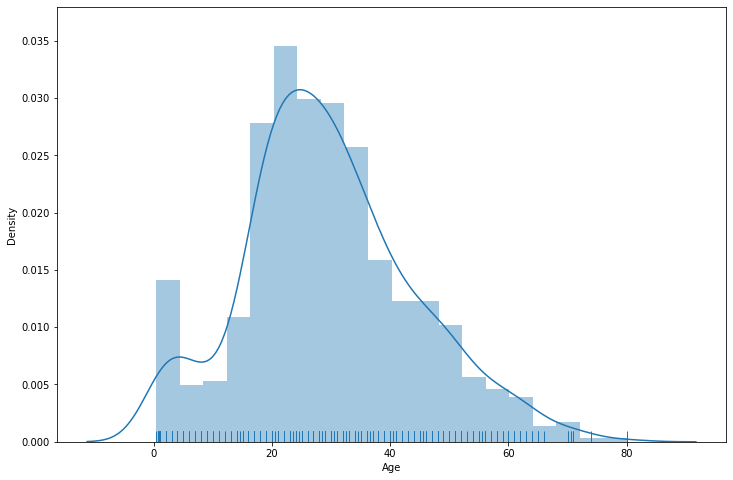

In [ ]:
plt.figure(figsize=(12,8))
sns.distplot(all_data_stat['Age'], rug=True)

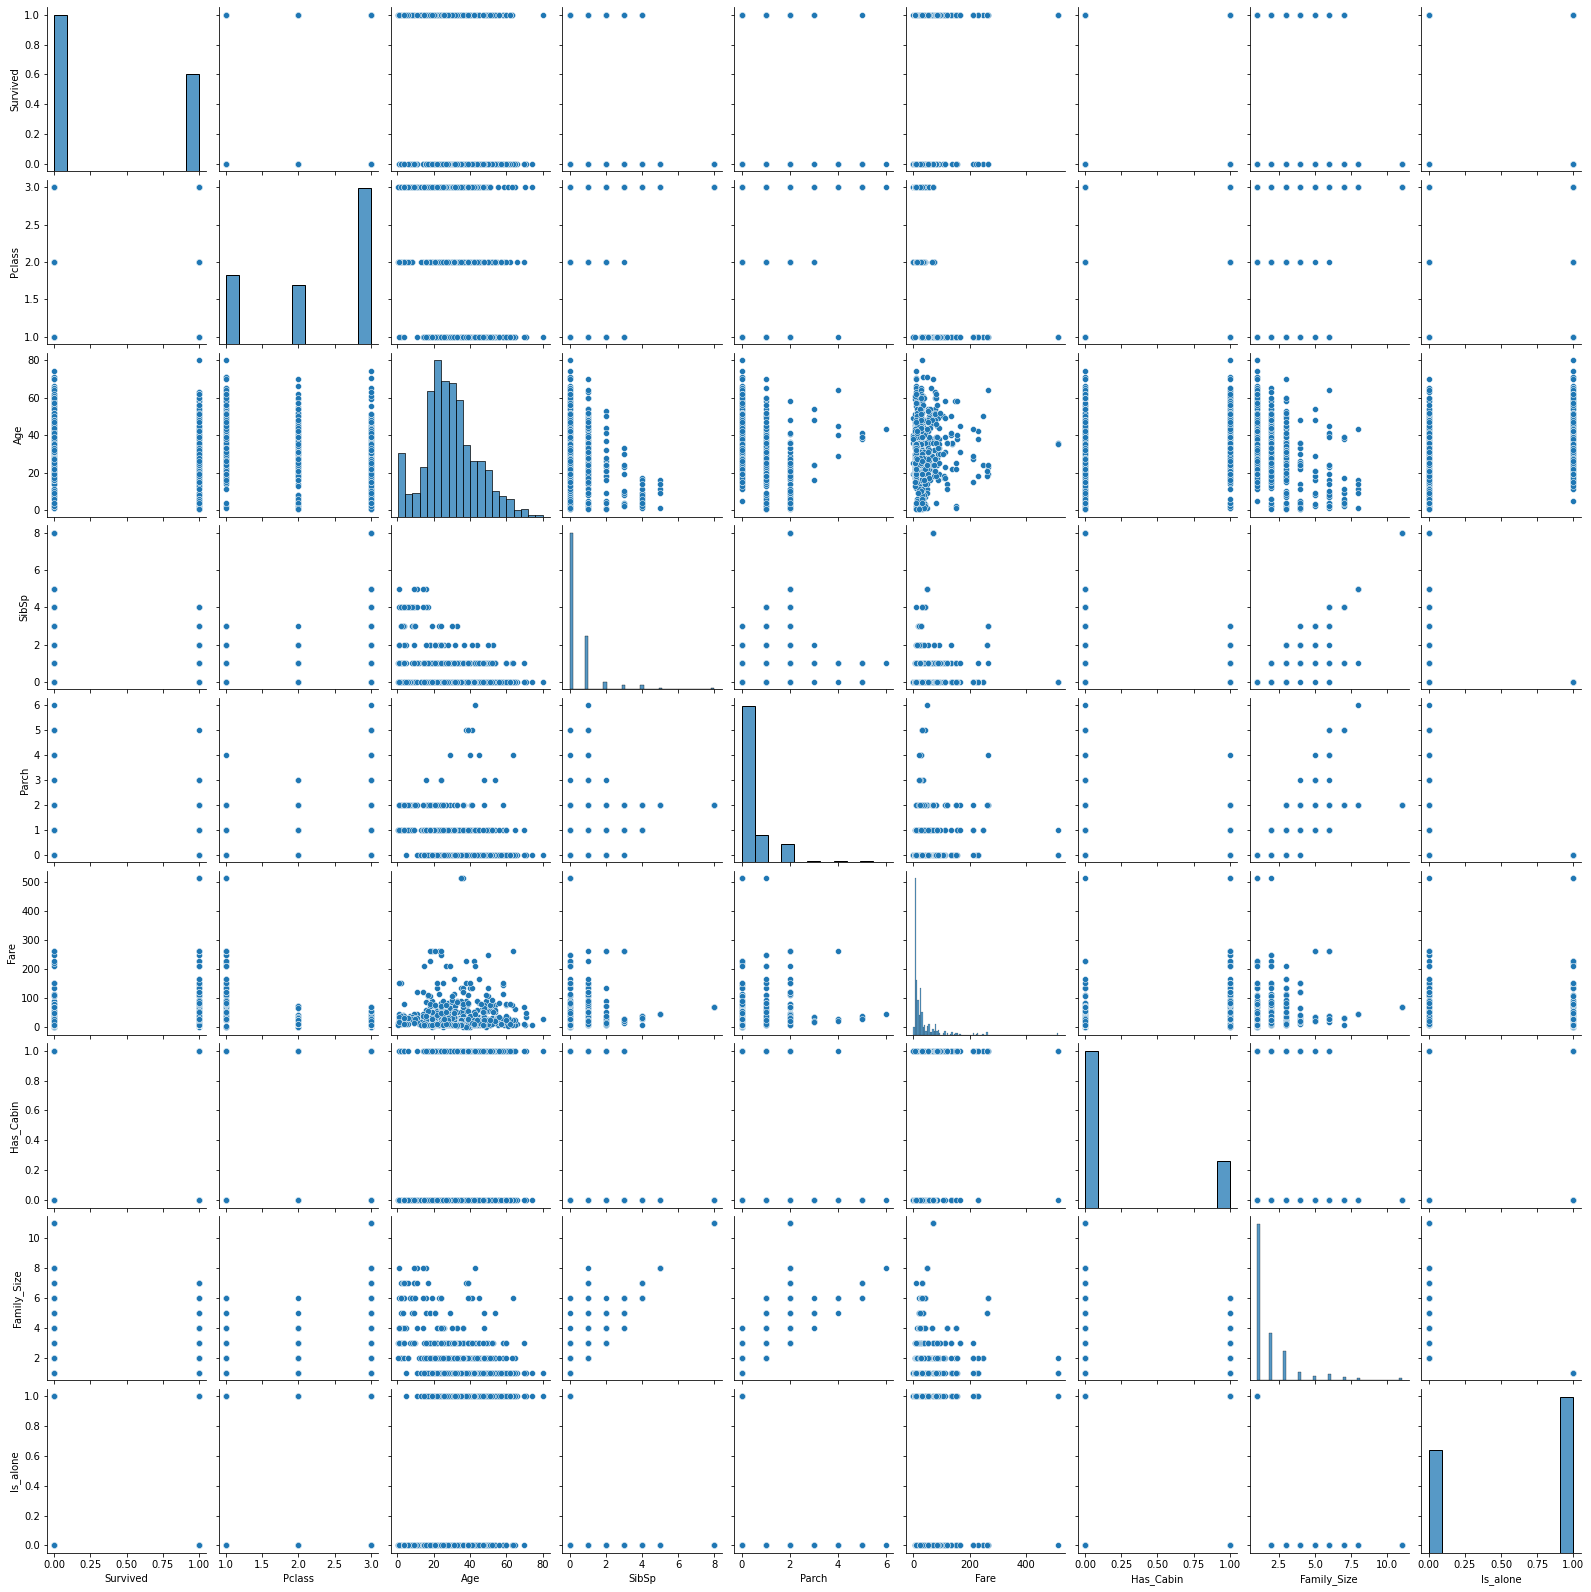

In [ ]:
sns.pairplot(all_data_stat)

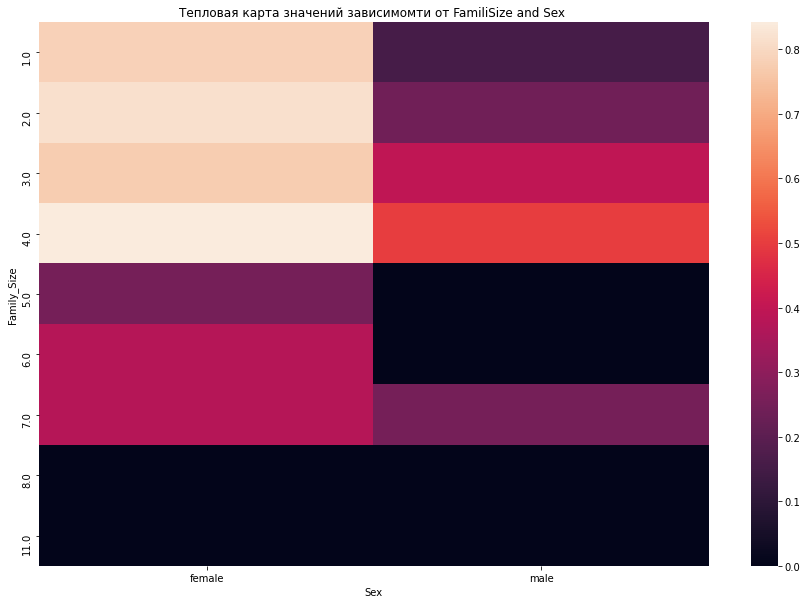

In [ ]:
plt.figure(figsize=(15,10))
plt.title('Тепловая карта значений зависимомти от FamiliSize and Sex ')

sns.heatmap(all_data_stat.groupby(['Family_Size', 'Sex'])['Survived'].mean().unstack().fillna(0))


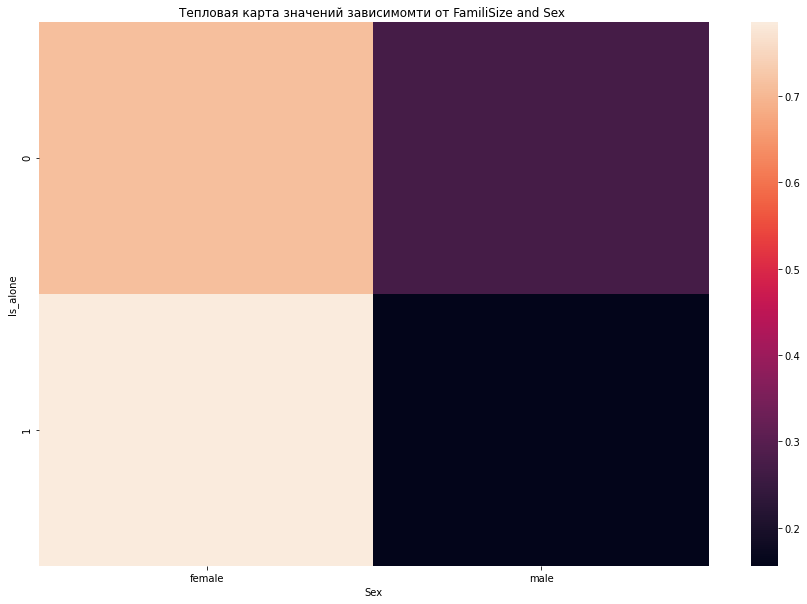

In [ ]:
plt.figure(figsize=(15,10))
plt.title('Тепловая карта значений зависимомти от FamiliSize and Sex ')

sns.heatmap(all_data_stat.groupby(['Is_alone', 'Sex'])['Survived'].mean().unstack().fillna(0))


In [ ]:
# Переводим оставшиеся недообработанные столбцы в числовой вид
title_mapping = {'Mr': 1, "Master": 2, "Mrs":3, "Miss":4, "Rare": 5}
all_data_stat["Title"] = all_data_stat["Title"].map(title_mapping)
all_data_stat["Title"] = all_data_stat['Title'].fillna(0) # здесь не нужен, но всёравно сделаем

In [ ]:
# Преобразуем в числовую форму эти колонки
map_dict_sex = {'male': 1, 'female': 0}

all_data_stat["Sex"] = all_data_stat["Sex"].map(map_dict_sex)

In [ ]:
map_dict_embarked = {'S': 0, 'C': 1, 'Q': 2}

all_data_stat['Embarked'] = all_data_stat['Embarked'].map(map_dict_embarked)

In [ ]:
all_data_stat.corr()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Has_Cabin,Family_Size,Is_alone,Title
Survived,1.000000,-0.338481,-0.543351,-0.077221,-0.035322,0.081629,0.257307,0.108669,0.316912,0.016639,-0.203367,0.488326
Pclass,-0.338481,1.000000,0.131900,-0.369226,0.083081,0.018443,-0.549500,0.043835,-0.725541,0.065997,0.135207,-0.161730
Sex,-0.543351,0.131900,1.000000,0.093254,-0.114631,-0.245489,-0.182333,-0.118593,-0.140391,-0.200988,0.303646,-0.854773
Age,-0.077221,-0.369226,0.093254,1.000000,-0.308247,-0.189119,0.096067,0.012186,0.249732,-0.301914,0.198270,-0.119977
SibSp,-0.035322,0.083081,-0.114631,-0.308247,1.000000,0.414838,0.159651,-0.060606,-0.040460,0.890712,-0.584471,0.151257
Parch,0.081629,0.018443,-0.245489,-0.189119,0.414838,1.000000,0.216225,-0.079320,0.036987,0.783111,-0.583398,0.222949
Fare,0.257307,-0.549500,-0.182333,0.096067,0.159651,0.216225,1.000000,0.063462,0.482075,0.217138,-0.271832,0.172321
Embarked,0.108669,0.043835,-0.118593,0.012186,-0.060606,-0.079320,0.063462,1.000000,0.016190,-0.081057,0.018867,0.141448
Has_Cabin,0.316912,-0.725541,-0.140391,0.249732,-0.040460,0.036987,0.482075,0.016190,1.000000,-0.009175,-0.158029,0.133338
Family_Size,0.016639,0.065997,-0.200988,-0.301914,0.890712,0.783111,0.217138,-0.081057,-0.009175,1.000000,-0.690922,0.214761


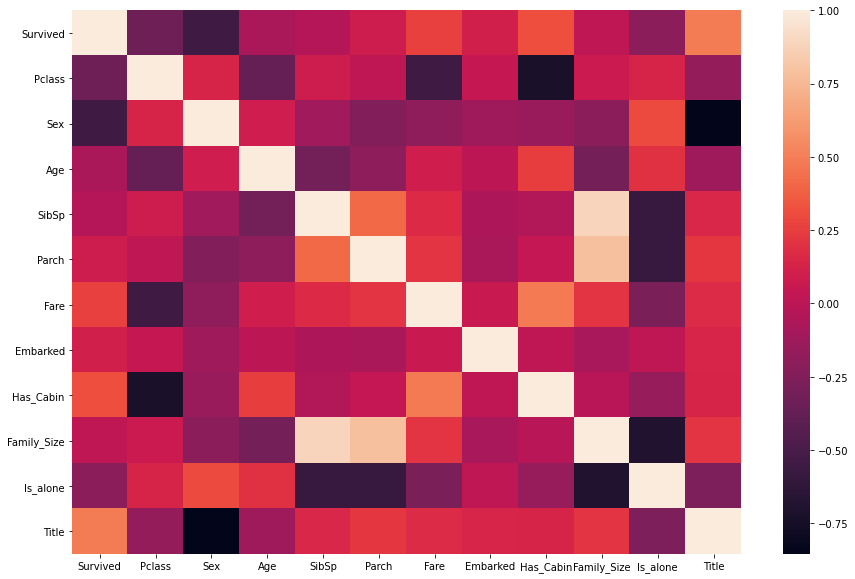

In [ ]:
plt.figure(figsize=(15,10))

sns.heatmap(all_data_stat.corr())

In [ ]:
all_data_stat

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Has_Cabin,Family_Size,Is_alone,Title
PassengerId,,,,,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,0.0,0,2.0,0,1.0
2,1,1,0,38.0,1,0,71.2833,1.0,1,2.0,0,3.0
3,1,3,0,26.0,0,0,7.9250,0.0,0,1.0,1,4.0
4,1,1,0,35.0,1,0,53.1000,0.0,1,2.0,0,3.0
5,0,3,1,35.0,0,0,8.0500,0.0,0,1.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,1,27.0,0,0,13.0000,0.0,0,1.0,1,5.0
888,1,1,0,19.0,0,0,30.0000,0.0,1,1.0,1,4.0
889,0,3,0,NaN,1,2,23.4500,0.0,0,4.0,0,4.0


In [ ]:
all_data_stat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Sex          891 non-null    int64  
 3   Age          714 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   Embarked     889 non-null    float64
 8   Has_Cabin    891 non-null    int64  
 9   Family_Size  891 non-null    float64
 10  Is_alone     891 non-null    int64  
 11  Title        891 non-null    float64
dtypes: float64(5), int64(7)
memory usage: 130.5 KB


In [ ]:
# Избавление от пропусков  
all_data_stat['Embarked'] = all_data_stat['Embarked'].fillna(value=0)


In [ ]:
# Среднее арифметическое для возраста
all_data_stat['Age'] = all_data_stat['Age'].fillna(value = all_data_stat['Age'].mean())

In [ ]:
all_data_stat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Sex          891 non-null    int64  
 3   Age          891 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   Embarked     891 non-null    float64
 8   Has_Cabin    891 non-null    int64  
 9   Family_Size  891 non-null    float64
 10  Is_alone     891 non-null    int64  
 11  Title        891 non-null    float64
dtypes: float64(5), int64(7)
memory usage: 130.5 KB


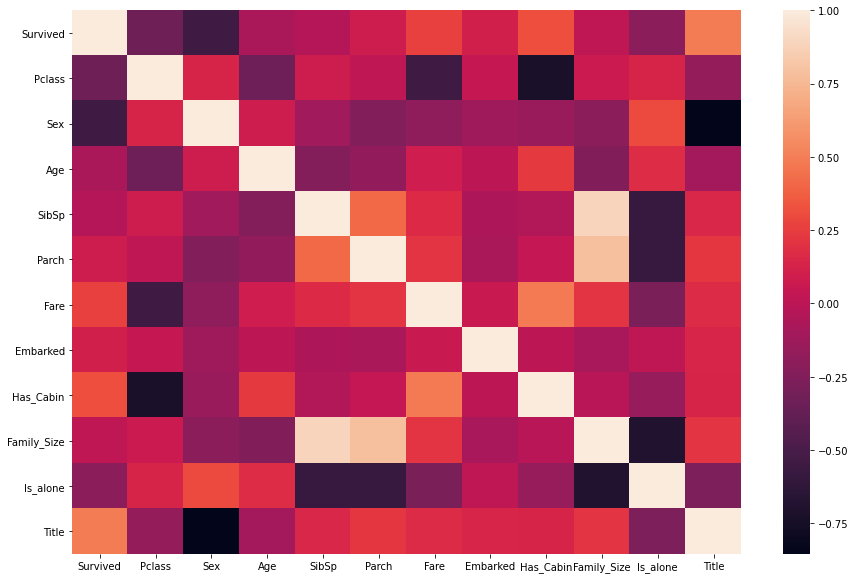

In [ ]:
plt.figure(figsize=(15, 10))

sns.heatmap(all_data_stat.corr())